RA of Asteroid:
RA: 20 : 43 : 34.23
Declination of Asteroid:
Dec: -5 : 32 : 33.9
  RAresisuals DECresiduals
0 -14.49      3.79
1 2.52      -0.8
2 20.81      -5.19
3 -7.67      1.89
4 -17.8      4.52
5 16.63      -4.21
sigmaRA: 20.8
sigmaDEC: 5.3


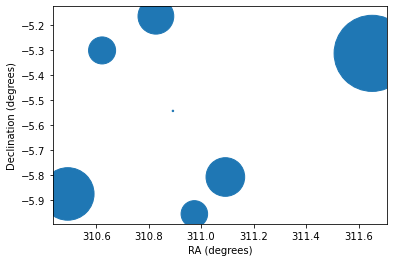

In [24]:
import numpy as np  
from odlib import *
import matplotlib.pyplot as plt

def SpliceColumn(Coeff, Const, j):
    Coeff[:, j] = Const
    return Coeff
    
def Cramer(Coeff, Const):
    D = np.linalg.det(Coeff)
    x = np.linalg.det(SpliceColumn(np.copy(Coeff), Const, 0)) / D
    y = np.linalg.det(SpliceColumn(np.copy(Coeff), Const, 1)) / D
    
    if len(Coeff) == 2:
        return [x, y]
    
    z = np.linalg.det(SpliceColumn(np.copy(Coeff), Const, 2)) / D
    return [x, y, z]

# x  y  RA:hr min sec  Dec:deg m s
def InputCSV():
    data = np.loadtxt('/home/vumat/Desktop/Python_Code/star_info.csv', dtype=float, delimiter=',')
    return np.array(data)

def DECdecimalToDMS(dec):
    d = trunc(dec)
    dec = abs(dec) - abs(d)
    m = trunc(dec / (1/60))
    dec -= (m * (1/60))
    s = dec / (1/3600)
    print ("Dec:", d, ":", m, ":", round(s, 2))
    
def RAdecimalToHMS(val):
    h = trunc(val / 15)
    val = (abs(val) / 15) - abs(h)
    m = trunc(val / (1/60))
    val = val - (m * (1/60))
    s = val / (1/3600)
    print ("RA:", h, ":", m, ":", round(s, 2))

def GetRADecUnc(data):
    rawStarData = data[0:len(data) - 1, 0:len(data[0])]
    starMag = data[:, 8]
    
    asteroidX = data[len(data) - 1][0]
    asteroidY = data[len(data) - 1][1]
    
    newStarData = np.zeros((len(data) - 1, len(data[0]) - 4))
    for i in range(0, len(newStarData)):
        newStarData[i][0] = rawStarData[i][0]
        newStarData[i][1] = rawStarData[i][1]
        newStarData[i][2] = HMStoDegOrRad(rawStarData[i][2], rawStarData[i][3], rawStarData[i][4], True)
        newStarData[i][3] = DMStoDeg(rawStarData[i][5], rawStarData[i][6], rawStarData[i][7])
        
    sumA = sumAX = sumAY = sumX = sumY = sumX2 = sumXY = sumY2 = sumD = sumDX = sumDY = 0
    N = len(rawStarData)
    
    #print(newStarData)
    
    for i in range(0, len(newStarData)):
        sumA += newStarData[i][2]
        sumAX += newStarData[i][2] * newStarData[i][0]
        sumAY += newStarData[i][2] * newStarData[i][1]
        sumX += newStarData[i][0]
        sumY += newStarData[i][1]
        sumX2 += newStarData[i][0] ** 2
        sumXY += newStarData[i][0] * newStarData[i][1]
        sumY2 += newStarData[i][1] ** 2
        sumD += newStarData[i][3]
        sumDX += newStarData[i][3] * newStarData[i][0]
        sumDY += newStarData[i][3] * newStarData[i][1]
        
    coeffM = np.array([[N, sumX, sumY], [sumX, sumX2, sumXY], [sumY, sumXY, sumY2]])
    constMA = np.array([sumA, sumAX, sumAY])
    constMD = np.array([sumD, sumDX, sumDY])
    
    [b1, a11, a12] = Cramer(coeffM, constMA)
    [b2, a21, a22] = Cramer(coeffM, constMD)
    
    asteroidA = b1 + a11 * asteroidX + a12 * asteroidY
    asteroidD = b2 + a21 * asteroidX + a22 * asteroidY
    
    resA2 = np.zeros((1, N))
    resD2 = np.zeros((1, N))
    
    for i in range(0, N):
        resA2[0][i] = (newStarData[i][2] - (b1 + a11 * newStarData[i][0] + a12 * newStarData[i][1])) ** 2
        resD2[0][i] = (newStarData[i][3] - (b2 + a21 * newStarData[i][0] + a22 * newStarData[i][1])) ** 2
    
    sumResA2 = sumResD2 = 0
    for i in range(0, N):
        sumResA2 += resA2[0][i]
        sumResD2 += resD2[0][i]
        
    uncA = np.sqrt((1/(N-3)) * sumResA2)
    uncD = np.sqrt((1/(N-3)) * sumResD2)
        
    #print('RA of Asteroid:', asteroidA, '+/-', uncA)
    print('RA of Asteroid:')
    RAdecimalToHMS(asteroidA)
    
    #print('Declination of Asteroid:', asteroidD, '+/-', uncD)
    print('Declination of Asteroid:')
    DECdecimalToDMS(asteroidD)
    
    
    RAresiduals = [round(((newStarData[i][2] - (b1 + a11 * newStarData[i][0] + a12 * newStarData[i][1]))) * 3600, 2) for i in range(N)]
    DECresiduals = [round(((newStarData[i][3] - (b2 + a21 * newStarData[i][0] + a22 * newStarData[i][1]))) * 3600, 2) for i in range(N)]
    
    print('  RAresisuals', 'DECresiduals')
    for i in range(N):
        print(i, RAresiduals[i], '    ', DECresiduals[i])
        
    print('sigmaRA:', round(uncA * 3600, 1))
    print('sigmaDEC:', round(uncD * 3600, 1))
    
    plotX = newStarData[:, 2]
    plotX = np.append(plotX, asteroidA)
    plotY = newStarData[:, 3]
    plotY = np.append(plotY, asteroidD)

    # Size of asteroid scaled up
    starMag[len(starMag) - 1] = 300 * (uncA + uncD) 
    area = 2.5 ** starMag * 0.3
    
    plt.xlabel('RA (degrees)')
    plt.ylabel('Declination (degrees)')
    plt.scatter(plotX, plotY, area)

#print(Cramer(np.array([[1, 3], [2, -1]]), np.array([8, 9])))
GetRADecUnc(InputCSV())
    

    